<a href="https://colab.research.google.com/github/ToyTeX/Notebooks/blob/main/CholeskyFactorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Numerical solutions at (3/4, 3/4):
h = 1/ 4 = 0.25000000: u(3/4, 3/4) = 0.4285714285714285
h = 1/ 8 = 0.12500000: u(3/4, 3/4) = 0.4310530568273633
h = 1/16 = 0.06250000: u(3/4, 3/4) = 0.4317789908889220
h = 1/32 = 0.03125000: u(3/4, 3/4) = 0.4319657109505001


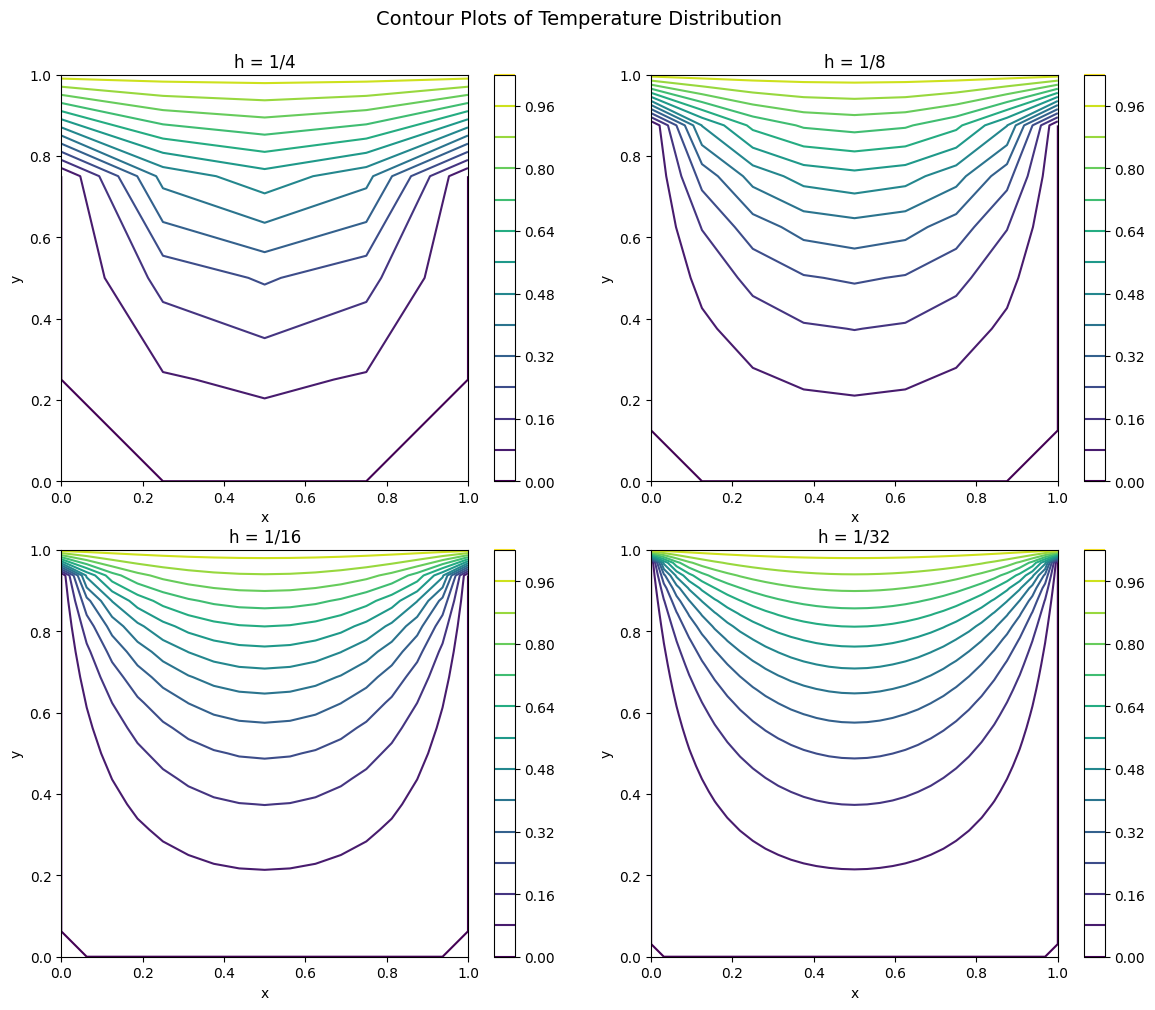

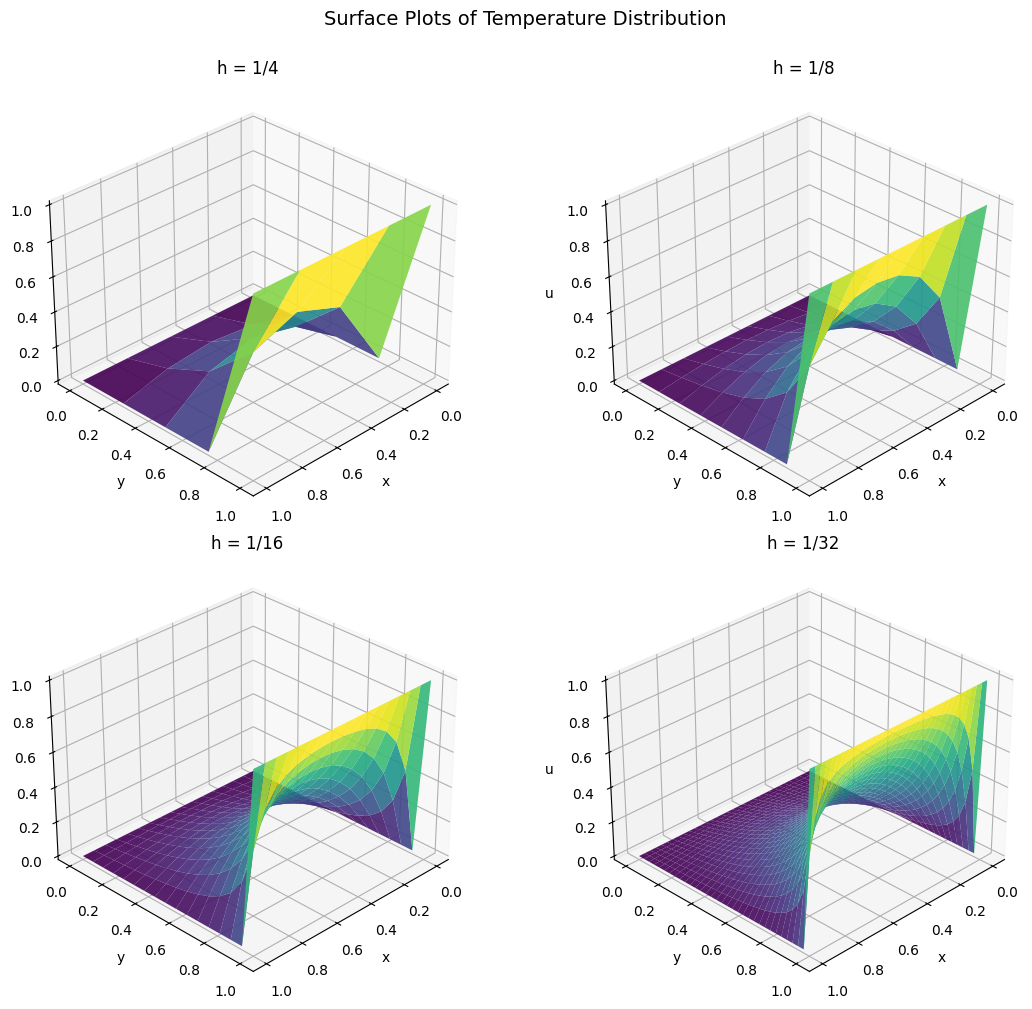


Convergence Analysis:

|u(h=0.125000) - u(h=0.250000)| = 0.0024816282559348

|u(h=0.062500) - u(h=0.125000)| = 0.0007259340615586
Ratio of consecutive errors: 0.292523
Estimated convergence rate: 1.7734

|u(h=0.031250) - u(h=0.062500)| = 0.0001867200615781
Ratio of consecutive errors: 0.257214
Estimated convergence rate: 1.9590


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def cholesky_factorization(A):
    """
    Perform Cholesky factorization
    Based on algorithm from page 54 of notes
    """
    n = A.shape[0]
    L = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1):
            if i == j:
                # Diagonal elements
                sum_val = np.sum(L[i, :j]**2)
                L[i, i] = np.sqrt(A[i, i] - sum_val)
            else:
                # Off-diagonal elements
                sum_val = np.sum(L[i, :j] * L[j, :j])
                L[i, j] = (A[i, j] - sum_val) / L[j, j]

    return L

def cholesky_solve(A, b):
    """
    Solve Ax = b using Cholesky factorization
    """
    # Perform Cholesky factorization
    L = cholesky_factorization(A)

    # Forward substitution: solve Ly = b
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]

    # Backward substitution: solve L^T x = y
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(L[i+1:, i], x[i+1:])) / L[i, i]

    return x

def solve_laplace_2d():
    """
    Solve 2D Laplace equation with 5-point stencil
    """
    results = {}

    # Create figures for contour and surface plots
    fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))
    fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})
    axes1 = axes1.flatten()
    axes2 = axes2.flatten()

    print("Numerical solutions at (3/4, 3/4):")
    print("=" * 60)

    for idx, p in enumerate(range(2, 6)):
        n = 2**p - 1
        N = n**2
        h = 1/(n+1)

        # Create matrix A (5-point Laplacian)
        A = np.zeros((N, N))

        # Diagonal elements
        for i in range(N):
            A[i, i] = 4

        # Off-diagonal elements (left-right connections)
        for i in range(1, N):
            A[i, i-1] = -1
            A[i-1, i] = -1

        # Up-down connections
        for i in range(n, N):
            A[i, i-n] = -1
            A[i-n, i] = -1

        # Remove connections across vertical boundaries
        for i in range(1, n):
            A[i*n, i*n-1] = 0
            A[i*n-1, i*n] = 0

        # Right-hand side (boundary condition u(x,1) = 1)
        b = np.zeros(N)
        b[N-n:N] = 1.0

        # Solve using Cholesky factorization
        x = cholesky_solve(A, b)

        # Transform solution vector to 2D array for plotting
        u = np.zeros((n+2, n+2))
        u[-1, :] = 1.0  # Top boundary condition

        for i in range(n):
            for j in range(n):
                u[j+1, i+1] = x[i + j*n]

        # Find value at (3/4, 3/4)
        x_idx = int(0.75 / h)
        y_idx = int(0.75 / h)
        u_val = u[y_idx, x_idx]

        results[h] = u_val
        print(f"h = 1/{n+1:2d} = {h:.8f}: u(3/4, 3/4) = {u_val:.16f}")

        # Create coordinate arrays
        coords = np.linspace(0, 1, n+2)
        X, Y = np.meshgrid(coords, coords)

        # Contour plot
        contour = axes1[idx].contour(X, Y, u, levels=15)
        axes1[idx].set_title(f'h = 1/{n+1}')
        axes1[idx].set_xlabel('x')
        axes1[idx].set_ylabel('y')
        axes1[idx].set_aspect('equal')
        fig1.colorbar(contour, ax=axes1[idx])

        # Surface plot
        axes2[idx].plot_surface(X, Y, u, cmap='viridis', edgecolor='none', alpha=0.9)
        axes2[idx].set_title(f'h = 1/{n+1}')
        axes2[idx].set_xlabel('x')
        axes2[idx].set_ylabel('y')
        axes2[idx].set_zlabel('u')
        axes2[idx].view_init(elev=30, azim=45)

    fig1.suptitle('Contour Plots of Temperature Distribution', fontsize=14, y=1.00)
    fig1.tight_layout()

    fig2.suptitle('Surface Plots of Temperature Distribution', fontsize=14, y=1.00)
    fig2.tight_layout()

    plt.show()

    # Analyze convergence
    print("\n" + "=" * 60)
    print("Convergence Analysis:")
    print("=" * 60)

    h_values = sorted(results.keys(), reverse=True)
    for i in range(len(h_values)-1):
        h1, h2 = h_values[i], h_values[i+1]
        u1, u2 = results[h1], results[h2]
        diff = abs(u2 - u1)
        print(f"\n|u(h={h2:.6f}) - u(h={h1:.6f})| = {diff:.16f}")

        if i > 0:
            h0 = h_values[i-1]
            u0 = results[h0]
            diff_prev = abs(u1 - u0)
            ratio = diff / diff_prev
            rate = np.log(ratio) / np.log(0.5)
            print(f"Ratio of consecutive errors: {ratio:.6f}")
            print(f"Estimated convergence rate: {rate:.4f}")


    return results

# Run the solver
results = solve_laplace_2d()


The numerical solution converges as h → 0, with a convergence rate of approximately 2.  The error also decreases by about 4.

As h decreases and the mesh gets finer, the values of u(3/4, 3/4) approach a limiting value/stabilizing and the differences between consecutive solutions get smaller, implying the convergence.  

 These results areall expected for the 5-point finite difference scheme (O(h²) accuracy).  